In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from classes.paths import LocalPaths
from classes.classes import ColorManager
from evaluation.utils import load_wandb_runs
from dotenv import load_dotenv
from evaluation.evaluation_metrics import SelectedRuntime
from evaluation.utils import get_model_results
import pandas as pd
from classes.workloads import EvalWorkloads
from classes.classes import MODEL_CONFIGS
from classes.classes import ModelName
import matplotlib.patches as mpatches
from cross_db_benchmark.datasets.datasets import Database

load_dotenv()
sns.set_theme(style="whitegrid", font_scale=1.8)
%load_ext autoreload
%autoreload 2

In [2]:
training_results = load_wandb_runs(wandb_user= os.environ["WANDB_USER"], 
                                   wandb_project=os.environ["WANDB_PROJECT"], 
                                   result_dir=LocalPaths().data / "training"/ "results.csv", 
                                   model_confs=MODEL_CONFIGS)
training_results

,model,database,seed,val_time,val_num_tuples,val_loss,val_std,val_mse,val_mape,val_median_q_error_50,val_median_q_error_95,val_median_q_error_100,test_time,no_test_points,display_name
0,postgres,baseball,2,NaN,NaN,NaN,NaN,4.431795,8.437770,7.760199,23.804813,60.607624,0.000393,5000.0,Sc. Postgres
1,postgres,imdb,2,NaN,NaN,NaN,NaN,7.600937,3.047728,3.495369,13.968419,25.392546,0.000537,10000.0,Sc. Postgres
2,postgres,tpc_h,2,NaN,NaN,NaN,NaN,5.940187,4.319689,2.833187,19.890733,25.848415,0.000354,10000.0,Sc. Postgres
3,postgres,baseball,1,NaN,NaN,NaN,NaN,4.427171,8.499110,7.771549,23.977192,59.395131,0.000286,5000.0,Sc. Postgres
4,postgres,tpc_h,1,NaN,NaN,NaN,NaN,5.933778,4.302132,2.828099,19.809247,25.733105,0.000423,10000.0,Sc. Postgres
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,dace,imdb,1,6.766429,10048.0,0.467642,7.485918,4.656119,0.460529,1.278169,3.222375,9.312226,NaN,NaN,DACE
76,dace,tpc_h,1,6.263767,10048.0,0.514632,6.018817,4.616790,0.316243,1.278786,3.741360,26.321440,NaN,NaN,DACE
77,dace,imdb,0,5.513473,10048.0,0.468080,7.485918,4.452060,0.431560,1.281085,3.216513,9.422543,NaN,NaN,DACE
78,dace,tpc_h,0,6.377806,10048.0,0.498211,6.018817,4.664309,0.328196,1.296683,3.666642,26.694092,NaN,NaN,DACE


In [4]:
runtime_df = pd.DataFrame()
minimal_runtimes = []
for workload in EvalWorkloads.FullJoinOrder.imdb:
    results = get_model_results(workload, MODEL_CONFIGS)
    for model in MODEL_CONFIGS:
        model_results = results[results["model"] == model.name.DISPLAY_NAME]
        selected_runtime = SelectedRuntime().evaluate_metric(preds=model_results["prediction"], labels=model_results['runtime'])
        runtime_df.loc[model.name.DISPLAY_NAME, workload.get_workload_name()] = selected_runtime
    minimal_runtimes.append(model_results["label"].min())
runtime_df = runtime_df.sum(axis=1).reset_index()
runtime_df

,index,0
0,Sc. Postgres,517.903449
1,Flat Vector,566.397582
2,MSCN,711.990258
3,E2E,811.961112
4,Zero-Shot,530.463789
5,QPP-Net,765.422095
6,QueryFormer,830.274369
7,DACE,625.280916


/var/folders/6f/l772vx1s4zd9xhd99kx9535h0000gn/T/ipykernel_41359/2582189678.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  runtimes.set_yticklabels(runtimes.get_yticklabels(), fontsize=fontsize * 0.8)


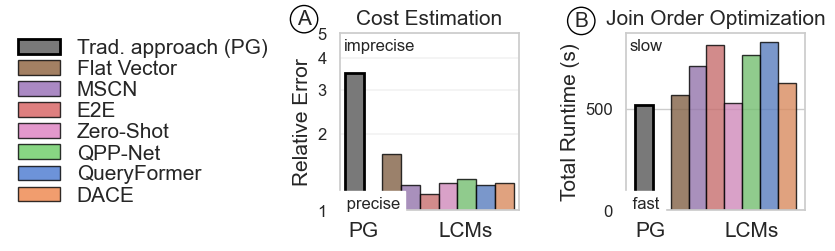

In [15]:
path = LocalPaths().data / "plots" / "motivating_plot.pdf"

fontsize = 15
fig, (q50, runtimes) = plt.subplots(1, 2, figsize=(6, 2.3))

# Filter only for database IMDB
training_results = training_results[training_results.database == "imdb"]
blank_row = pd.DataFrame({'model': ['test'], 'val_median_q_error_50' : 0.9, 'display_name': ['test']})
training_res = pd.concat([training_results[0:3], blank_row, training_results[3:]])
color_palette = ColorManager.COLOR_PALETTE
color_palette["test"] = "white"

blank_row = pd.DataFrame({'index': ['test'], 0: 0})
runtime_df = pd.concat([runtime_df[0:1], blank_row, runtime_df[1:]])

# ---------------------------- Plot Q50 ---------------------------- #
q50 = sns.barplot(x="database",
                  y="val_median_q_error_50",
                  hue="display_name",
                  data=training_res,
                  capsize=.0,
                  ax=q50,
                  width=1.0,
                  palette=color_palette,
                  errorbar=None,
                  edgecolor='black')

q50.set_ylim(1, 4)
q50.set_xlim(-0.53, 0.53)
q50.set_yscale("log")
q50.set_ylabel("Relative Error", fontsize=fontsize)
q50.set_xlabel("", fontsize=fontsize)

q50.set_yticks([1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5], minor=False, fontsize=fontsize * 0.8)
q50.set_xticklabels([])
q50.grid(False, axis='x', which='both')
q50.grid(True, axis='y', which='both', linewidth=0.3)
q50.set_title("Cost Estimation", fontsize=fontsize)

q50.get_legend().remove()

q50.annotate("imprecise",
              xy=(0.02, 0.90),
              xytext=(0.02, 0.90),
              fontsize=0.8 * fontsize,
              xycoords='axes fraction')

q50.annotate(" precise",
              xy=(0.01, 0.01),
              xytext=(0.01, 0.01),
              fontsize=0.8 * fontsize,
              xycoords='axes fraction',
              backgroundcolor='white')


sns.barplot(data=runtime_df,
            x='index', 
            palette=ColorManager.COLOR_PALETTE,
            hue='index',
            y=0, 
            ax=runtimes,
            width=1,
            edgecolor='black')
runtimes.set_xlabel('')
runtimes.set_title('Join Order Optimization', fontsize=fontsize)
runtimes.set_xticklabels([])
runtimes.set_ylabel("Total Runtime (s)", fontsize=fontsize)
runtimes.set_yticklabels(runtimes.get_yticklabels(), fontsize=fontsize * 0.8)

runtimes.annotate("slow",
                  xy=(0.02, 0.90),
                  xytext=(0.02, 0.90),
                  fontsize=0.8 * fontsize,
                  xycoords='axes fraction')

runtimes.annotate(" fast",
                  xy=(0.01, 0.01),
                  xytext=(0.01, 0.01),
                  fontsize=0.8 * fontsize,
                  xycoords='axes fraction',
                  backgroundcolor='white')

runtimes.annotate("LCMs", xy=(0.55, -0.15), fontsize=fontsize, xycoords='axes fraction')
q50.annotate("LCMs", xy=(0.55, -0.15), fontsize=fontsize, xycoords='axes fraction')

runtimes.annotate("PG", xy=(0.05, -0.15), fontsize=fontsize, xycoords='axes fraction')
q50.annotate("PG", xy=(0.05, -0.15), fontsize=fontsize, xycoords='axes fraction')
runtimes.set_xlim(-1, 9)

for ax in [q50, runtimes]:
    # Highlighting options
    bar_rects = ax.patches  # Get all the bar rectangles created by seaborn
    #bar_rects[0].set_width(1)  # Increase width of highlighted bar
    bar_rects[0].set_edgecolor('black')
    bar_rects[0].set_linewidth(2)
    bar_rects[0].set_zorder(2)
    for rect in bar_rects:
        rect.set_alpha(0.8)
    bar_rects[0].set_alpha(1.0)

legend_patches = [mpatches.Patch(color=color, label=model_name) for model_name, color in color_palette.items()][0:8]
legend_patches[0] = mpatches.Patch(label="Trad. approach (PG)", color=ColorManager.COLOR_PALETTE[ModelName.POSTGRES.DISPLAY_NAME])
for p in legend_patches[1:]:
    p.set_edgecolor('black')
    p.set_alpha(0.8)
legend_patches[0].set_edgecolor('black')
legend_patches[0].set_linewidth(2)
    
runtimes.legend(handles=legend_patches, 
                loc='center right', 
                bbox_to_anchor=(-1.9, 0.5), 
                edgecolor='white',  
                labelspacing=0.1,
                fontsize=fontsize)

q50.annotate(
    "A",
    xy=(-0.2, 1.08), 
    xycoords='axes fraction', 
    fontsize=fontsize, 
    ha='center', 
    va='center', 
    bbox=dict(boxstyle='circle,pad=0.2', edgecolor='black', facecolor='white'))

runtimes.annotate(
    "B",
    xy=(-0.25, 1.07), 
    xycoords='axes fraction', 
    fontsize=fontsize, 
    ha='center', 
    va='center', 
    bbox=dict(boxstyle='circle,pad=0.2', edgecolor='black', facecolor='white'))

#for i in runtimes.containers:
#    runtimes.bar_label(i,fmt='%.0f', label_type='edge', fontsize=fontsize*0.8)

plt.subplots_adjust(wspace=0.6)
fig.align_labels()
plt.savefig(path, bbox_inches='tight')


In [16]:
training_res

,model,database,seed,val_time,val_num_tuples,val_loss,val_std,val_mse,val_mape,val_median_q_error_50,val_median_q_error_95,val_median_q_error_100,test_time,no_test_points,display_name
1,postgres,imdb,2.0,NaN,NaN,NaN,NaN,7.600937,3.047728,3.495369,13.968419,25.392546,0.000537,10000.0,Sc. Postgres
5,postgres,imdb,1.0,NaN,NaN,NaN,NaN,7.588586,3.037842,3.484301,13.920369,25.323006,0.000489,10000.0,Sc. Postgres
6,postgres,imdb,0.0,NaN,NaN,NaN,NaN,7.608397,3.067449,3.502803,14.055457,25.540075,0.000524,10000.0,Sc. Postgres
0,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.900000,NaN,NaN,NaN,NaN,test
9,flat,imdb,2.0,NaN,NaN,NaN,NaN,4.094751,0.882702,1.673149,5.491129,450.527100,0.034493,10000.0,Flat Vector
13,flat,imdb,1.0,NaN,NaN,NaN,NaN,4.062295,0.867252,1.658704,5.468697,327.538300,0.051084,10000.0,Flat Vector
15,flat,imdb,0.0,NaN,NaN,NaN,NaN,3.990043,0.853231,1.686949,5.532055,789.353400,0.034591,10000.0,Flat Vector
20,mscn,imdb,2.0,0.975715,1024.0,1.612655e+00,7.179677,3.894115,0.445855,1.258485,3.326513,30.213089,NaN,NaN,MSCN
22,mscn,imdb,1.0,0.948403,1024.0,1.525215e+00,7.493614,3.701501,0.359707,1.250460,2.952815,12.664342,NaN,NaN,MSCN
24,mscn,imdb,0.0,0.997942,1024.0,1.554215e+00,7.774545,3.824459,0.382544,1.258688,2.901500,23.136833,NaN,NaN,MSCN


# Motivating metrics

/var/folders/6f/l772vx1s4zd9xhd99kx9535h0000gn/T/ipykernel_41418/3687512015.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  runtimes.set_yticklabels(runtimes.get_yticklabels(), fontsize=fontsize * 0.8)


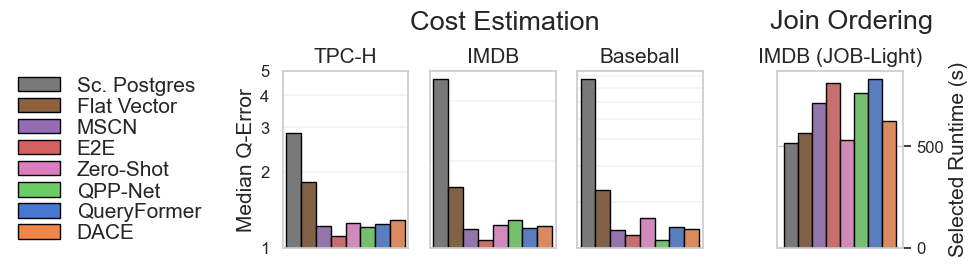

In [22]:
path = LocalPaths().data / "plots" / "motivating_metrics.pdf"

fontsize = 15
fig, (tpc_h_ax, imdb_ax, baseball_ax, empty, runtimes) = plt.subplots(1, 5, figsize=(8, 2.3), gridspec_kw=dict(width_ratios=[2,2,2,0.5,2]))

for q50, database in zip([tpc_h_ax, imdb_ax, baseball_ax], [Database("tpc_h", display_name="TPC-H"), Database("imdb", display_name="IMDB"), Database("baseball", "Baseball")]):
    results = training_results[training_results.database == database.db_name]
    # ---------------------------- Plot Q50 ---------------------------- #
    q50 = sns.barplot(x="database",
                      y="val_median_q_error_50",
                      hue="display_name",
                      data=results,
                      capsize=.0,
                      ax=q50,
                      width=1.0,
                      palette=ColorManager.COLOR_PALETTE,
                      errorbar=None,
                      edgecolor='black')
    
    q50.set_xlim(-0.53, 0.53)
    q50.set_yscale("log")
    q50.set_xlabel("", fontsize=fontsize)
    
    if database == Database("tpc_h", display_name="TPC-H"):
        q50.set_yticks([1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5], minor=False, fontsize=fontsize * 0.8)
    else:
        q50.set_yticks([])
        q50.set_yticklabels([],  minor=True)
    q50.set_xticklabels([])
    q50.grid(False, axis='x', which='both')
    q50.grid(True, axis='y', which='both', linewidth=0.3)
    q50.set_title(database.display_name, fontsize=fontsize)
    q50.set_ylabel("")
    q50.get_legend().remove()


sns.barplot(data=runtime_df, 
            x='index', 
            palette=ColorManager.COLOR_PALETTE,
            hue='index',
            y=0, 
            ax=runtimes,
            width=1,
            edgecolor='black')
runtimes.set_xlabel('')
runtimes.set_title('IMDB (JOB-Light)', fontsize=fontsize)
runtimes.set_xticklabels([])
runtimes.set_ylabel("Selected Runtime (s)", fontsize=fontsize)
runtimes.set_yticklabels(runtimes.get_yticklabels(), fontsize=fontsize * 0.8)

runtimes.set_xlim(-1, 8)


legend_patches = [mpatches.Patch(color=color, label=model_name) for model_name, color in ColorManager.COLOR_PALETTE.items()][0:8]
#legend_patches[0] = mpatches.Patch(label="Trad. approach (PG)", color=ColorManager.COLOR_PALETTE[ModelName.POSTGRES.DISPLAY_NAME])
for p in legend_patches:
    p.set_edgecolor('black')
#    p.set_alpha(0.8)
#legend_patches[0].set_edgecolor('black')
#legend_patches[0].set_linewidth(2)
    
tpc_h_ax.legend(handles=legend_patches, 
                loc='center right', 
                bbox_to_anchor=(-0.5, 0.5), 
                edgecolor='white',  
                labelspacing=0.1,
                fontsize=fontsize)
tpc_h_ax.set_ylabel("Median Q-Error", fontsize=fontsize)
imdb_ax.text(-0.7, 4.9, "Cost Estimation", fontsize=fontsize * 1.3)
runtimes.text(-1.5, 1080, "Join Ordering", fontsize=fontsize * 1.3)
runtimes.yaxis.tick_right()
runtimes.yaxis.set_label_position("right")
empty.remove()

#for i in runtimes.containers:
#    runtimes.bar_label(i,fmt='%.0f', label_type='edge', fontsize=fontsize*0.8)

plt.subplots_adjust(wspace=0.2)
fig.align_labels()
plt.savefig(path, bbox_inches='tight')

In [6]:
runtime_df

,index,0
0,Sc. Postgres,517.903449
1,Flat Vector,566.397582
2,MSCN,711.990258
3,E2E,811.961112
4,Zero-Shot,530.463789
5,QPP-Net,765.422095
6,QueryFormer,830.274369
7,DACE,625.280916
